In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pylab as plt
import os
import tensorflow_datasets as tfds

In [2]:
print(tf.__version__)
tfds.__version__

2.1.0


'4.0.0'

In [3]:
DATA_DIR = os.path.join("dataset")

(train_ds,valid_ds), info = tfds.load("eurosat/rgb", split=['train[:80%]','train[80%:]'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True,
                                     data_dir=DATA_DIR)

print(train_ds)
print(valid_ds)

<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((64, 64, 3), ()), types: (tf.uint8, tf.int64)>


In [4]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

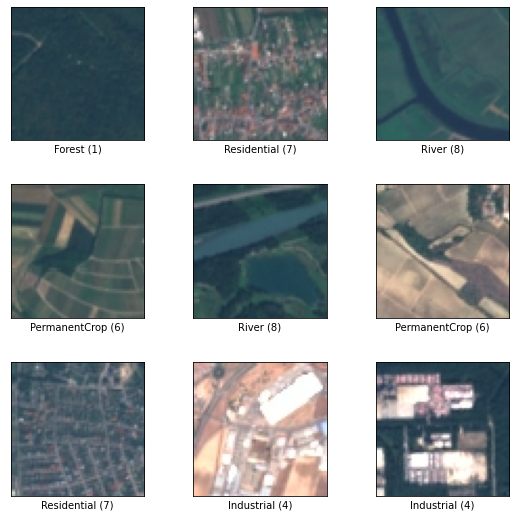

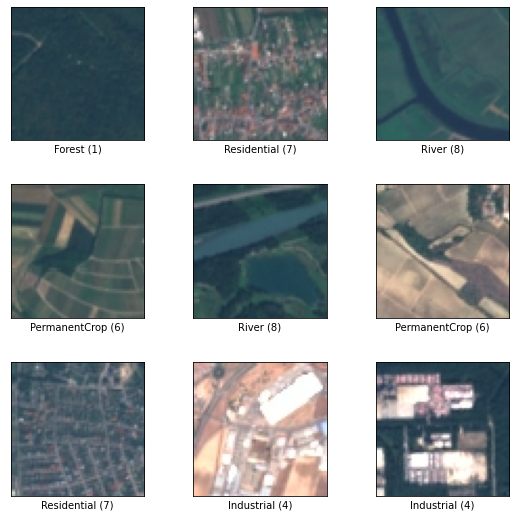

In [5]:
tfds.show_examples(train_ds,info)

,image,label
0,,9 (SeaLake)
1,,9 (SeaLake)
2,,9 (SeaLake)
3,,8 (River)
4,,9 (SeaLake)
5,,0 (AnnualCrop)
6,,2 (HerbaceousVegetation)
7,,0 (AnnualCrop)
8,,0 (AnnualCrop)
9,,2 (HerbaceousVegetation)

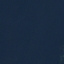
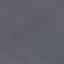
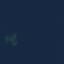
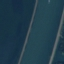
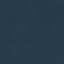
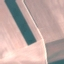
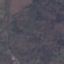
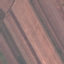
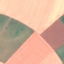
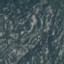

In [6]:
tfds.as_dataframe(valid_ds.take(10),info)
# 판다스 데이터프레임 형식으로 데이터를 표현

In [7]:
NUM_CLASSES = info.features["label"].num_classes

In [8]:
print(info.features["label"].int2str(6))

PermanentCrop


In [9]:
BATCH_SIZE = 65
BUFFER_SIZE = 1000

def preprocess_data(image, label):
    image = tf.cast(image, tf.float32) /255.
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = train_ds.map(preprocess_data, num_parallel_calls = AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls = AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [10]:
# Sequential API 모델 생성

def build_model():
    
    model = tf.keras.Sequential([
                                
    tf.keras.layers.BatchNormalization(), #배치 정규화
    tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
        
    tf.keras.layers.BatchNormalization(), #배치 정규화
    tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),  
        
    #Classifier 출력층
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dropout(0.3), # 과대 적합 방지하는 거였던가..?
    tf.keras.layers.Dense(64 ,activation='relu'),   
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax'),
    ])
    
    return model

model = build_model()

In [11]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

history = model.fit(train_data,
                   validation_data=valid_data,
                   epochs=50)

Epoch 1/50
333/333 [==============================] - 9s 26ms/step - loss: 1.6491 - accuracy: 0.4231 - val_loss: 1.8637 - val_accuracy: 0.3487
Epoch 2/50
333/333 [==============================] - 5s 17ms/step - loss: 1.2779 - accuracy: 0.5435 - val_loss: 0.9249 - val_accuracy: 0.6811
Epoch 3/50
333/333 [==============================] - 5s 16ms/step - loss: 1.0919 - accuracy: 0.6183 - val_loss: 0.8732 - val_accuracy: 0.6980
Epoch 4/50
333/333 [==============================] - 5s 16ms/step - loss: 0.9672 - accuracy: 0.6619 - val_loss: 0.7307 - val_accuracy: 0.7602
Epoch 5/50
333/333 [==============================] - 5s 16ms/step - loss: 0.8665 - accuracy: 0.6989 - val_loss: 0.6577 - val_accuracy: 0.7889
Epoch 6/50
333/333 [==============================] - 5s 16ms/step - loss: 0.8026 - accuracy: 0.7262 - val_loss: 0.5807 - val_accuracy: 0.8076
Epoch 7/50
333/333 [==============================] - 5s 16ms/step - loss: 0.7199 - accuracy: 0.7574 - val_loss: 0.6382 - val_accuracy: 0.7713

In [12]:
def plot_loss_acc(history, epoch): # Loss와 정확도를 출력하는 함수 정의
    
    loss,val_loss = history.history['loss'], history.history['val_loss']
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    # loss 손실값과, acc 정확도를 불러옴
    
    fig, axes = plt.subplots(1,2,figsize=(12,4))
    
    axes[0].plot(range(1,epoch+1),loss,label='Training')
    axes[0].plot(range(1,epoch+1),val_loss,label='Validation')
    axes[0].legend(loc='best')
    axes[0].set_title("Loss")
    
    axes[1].plot(range(1,epoch+1),acc,label='Training')
    axes[1].plot(range(1,epoch+1),val_acc,label='Validation')
    axes[1].legend(loc='best')
    axes[1].set_title("Accuracy")
    
    plt.show()


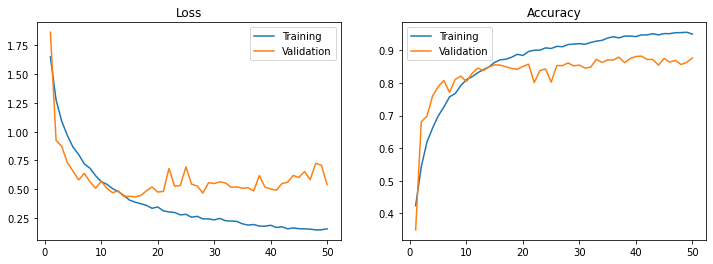

In [13]:
plot_loss_acc(history, 50)

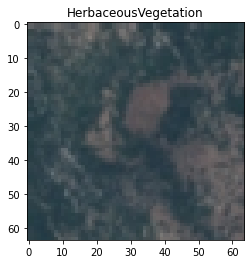

In [14]:
image_batch, label_batch = next(iter(train_data.take(1)))

image = image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features["label"].int2str(label));

In [15]:
def plot_augmentation(original, augmented):
    
    fig, axes = plt.subplots(1,2, figsize =(12,4))
    
    axes[0].imshow(original)
    axes[0].set_title('Original')
    
    axes[1].imshow(augmented)
    axes[1].set_title('Augmented')
    
    plt.show()
    
    

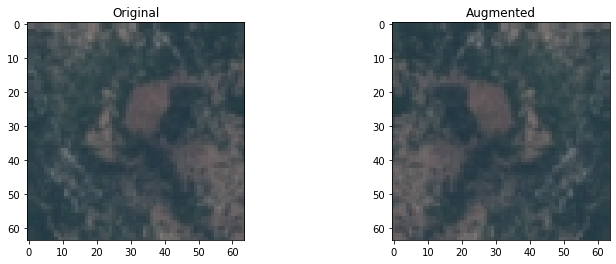

In [16]:
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image,lr_flip)

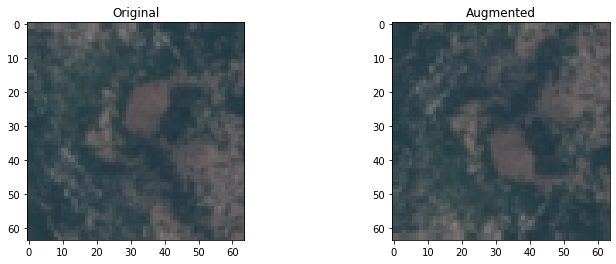

In [17]:
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

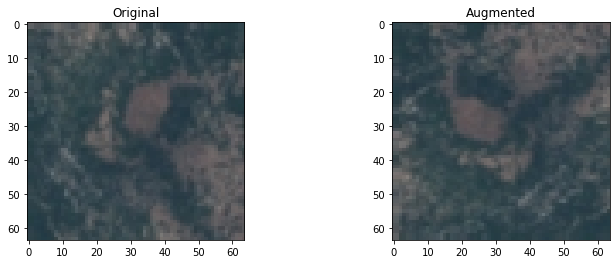

In [18]:
rotate90 = tf.image.rot90(image)
plot_augmentation(image,rotate90)

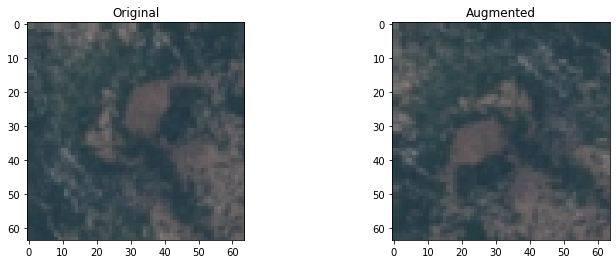

In [19]:
transpose = tf.image.transpose(image)
plot_augmentation(image,transpose)

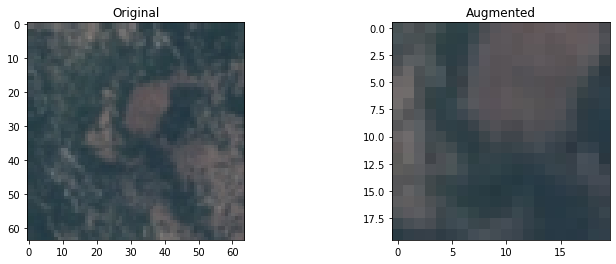

In [20]:
crop1 = tf.image.central_crop(image,central_fraction=0.3)
plot_augmentation(image,crop1)

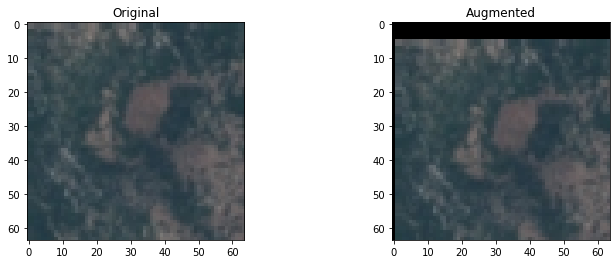

In [21]:
img = tf.image.resize_with_crop_or_pad(image,64+20,64+20)
crop2 = tf.image.random_crop(img,size=[64,64,3])
plot_augmentation(image,crop2)

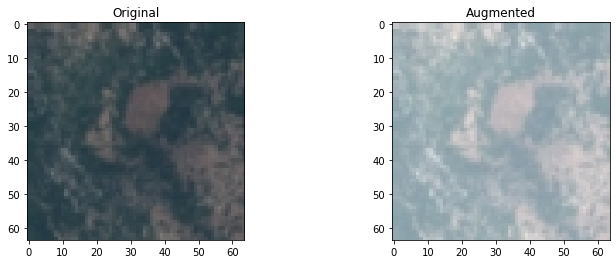

In [22]:
brightness = tf.image.adjust_brightness(image,delta=0.4)
plot_augmentation(image,brightness)

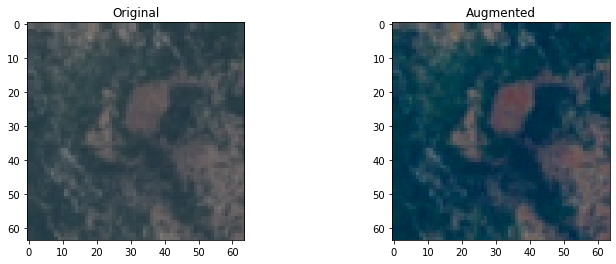

In [23]:
saturation = tf.image.adjust_saturation(image,saturation_factor=3)
plot_augmentation(image,saturation)

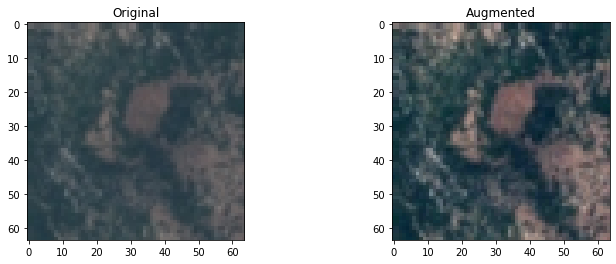

In [24]:
contrast = tf.image.adjust_contrast(image,contrast_factor=2)
plot_augmentation(image,contrast)

In [25]:
def data_augmentation(image, label):
    
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image,max_delta=0.3)
    image = tf.image.random_crop(image,size=[64,64,3])
    
    image = tf.cast(image,tf.float32) / 255.
    
    return image, label

AUTOTUNE = tf.data.experimental.AUTOTUNE


train_aug = train_ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=AUTOTUNE)

train_aug = train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_aug = valid_aug.batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

print(train_aug)
print(valid_aug)
    

<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>
<PrefetchDataset shapes: ((None, 64, 64, 3), (None,)), types: (tf.float32, tf.int64)>


In [26]:
aug_model = build_model()

aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

aug_histroy = aug_model.fit(train_aug, validation_data=valid_aug, epochs=50)

Epoch 1/50
333/333 [==============================] - 7s 21ms/step - loss: 1.8958 - accuracy: 0.2948 - val_loss: 1.8220 - val_accuracy: 0.3281
Epoch 2/50
333/333 [==============================] - 6s 17ms/step - loss: 1.6110 - accuracy: 0.3792 - val_loss: 1.3456 - val_accuracy: 0.5085
Epoch 3/50
333/333 [==============================] - 6s 17ms/step - loss: 1.4395 - accuracy: 0.4467 - val_loss: 1.2685 - val_accuracy: 0.5456
Epoch 4/50
333/333 [==============================] - 6s 17ms/step - loss: 1.2956 - accuracy: 0.5096 - val_loss: 0.9960 - val_accuracy: 0.6474
Epoch 5/50
333/333 [==============================] - 6s 17ms/step - loss: 1.2142 - accuracy: 0.5542 - val_loss: 0.9392 - val_accuracy: 0.6907
Epoch 6/50
333/333 [==============================] - 6s 17ms/step - loss: 1.1401 - accuracy: 0.5829 - val_loss: 1.0221 - val_accuracy: 0.6570
Epoch 7/50
333/333 [==============================] - 6s 17ms/step - loss: 1.0714 - accuracy: 0.6144 - val_loss: 0.8704 - val_accuracy: 0.7167

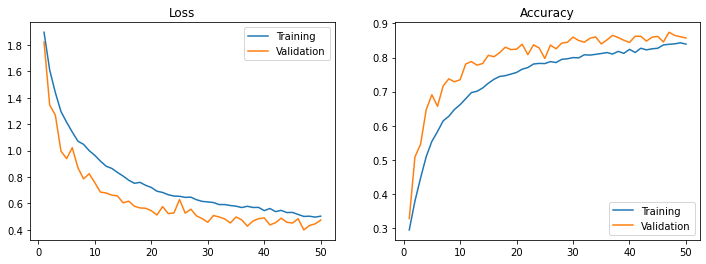

In [27]:
aug_history = aug_histroy
plot_loss_acc(aug_history, 50)

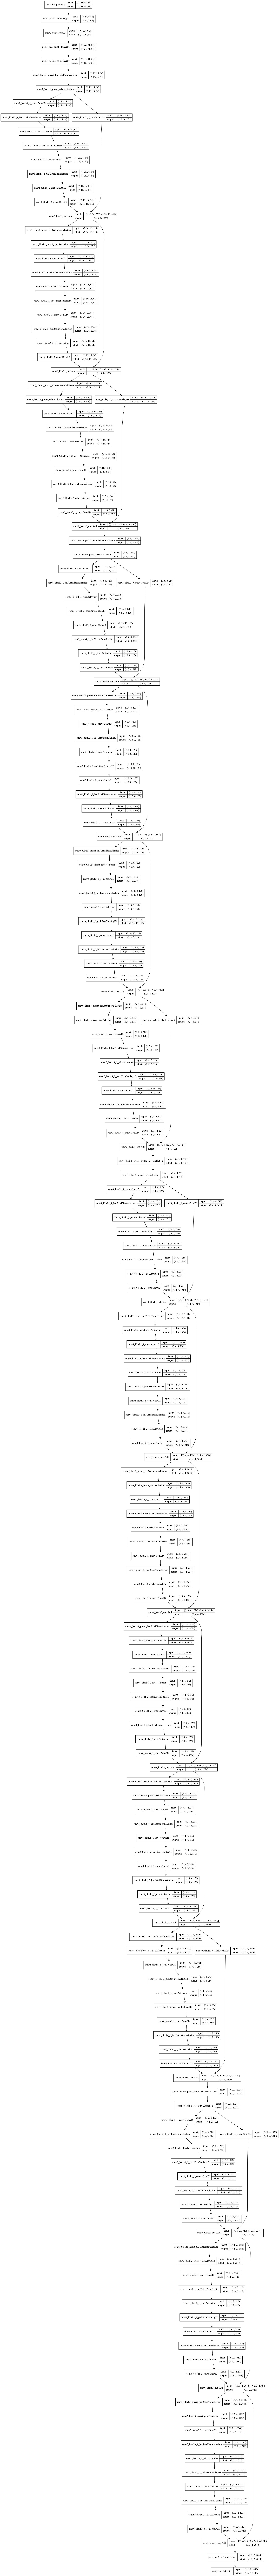

In [28]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False,
                             weights ='imagenet',
                             input_shape=[64,64,3])

pre_trained_base.trainable = False

from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')